In [ ]:
import numpy as np
import pandas as pd
import random
import math
from copy import deepcopy

#DataFrame Initialization

customer_ids = list(range(1, 25))

x_coords = [148, 44, 113, 88, 90, 64, 210, 163, 210, 174, 262, 250, 193, 188, 270, 139, 228, 220, 69, 95, 108, 49, 146, 44]
y_coords = [143, 159, 182, 165, 243, 218, 259, 227, 212, 183, 248, 175, 188, 214, 143, 109, 71, 113, 84, 125, 61, 100, 75, 130]
demands = [49, 144, 150, 78, 217, 280, 164, 133, 232, 268, 92, 309, 265, 316, 192, 103, 329, 284, 70, 330, 302, 338, 292, 123]

time_window_acceptable_start = [300, 540, 980, 640, 900, 700, 293, 1065, 709, 902, 475, 1080, 642, 764, 1104, 378, 1110, 998, 1147, 1025, 438, 590, 829, 384]
time_window_acceptable_end = [420, 660, 1100, 760, 1020, 820, 413, 1185, 829, 1022, 595, 1200, 762, 884, 1224, 498, 1230, 1118, 1267, 1145, 558, 710, 949, 504]

time_window_required_start = [340, 580, 1020, 300, 940, 740, 333, 1105, 749, 942, 515, 1120, 682, 804, 1144, 418, 1150, 1038, 1187, 1065, 478, 630, 869, 424]
time_window_required_end = [380, 620, 1060, 340, 980, 780, 373, 1145, 789, 982, 555, 1160, 722, 844, 1184, 458, 1190, 1078, 1227, 1105, 518, 670, 909, 464]

customers = pd.DataFrame({
    'id': customer_ids,
    'x': x_coords,
    'y': y_coords,
    'demand': demands,
    'time_acc_start': time_window_acceptable_start,
    'time_acc_end': time_window_acceptable_end,
    'time_req_start': time_window_required_start,
    'time_req_end': time_window_required_end
})

depot = {'id': 0, 'x': 80, 'y': 90}

# --- Parameters ---
num_vehicles = 5
vehicle_capacity = 1100
vehicle_transport_cost_per_km = 5
vehicle_fixed_cost = 2000
SERVICE_TIME = 3  # in minutes
max_penalty_per_vehicle = 500
max_transport_cost_per_vehicle = 0
max_total_transport_cost = 0

PARTICLE_SIZE = 40  # population size
MAX_ITER = 300      # iterations

# --- Distance Matrix ---
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

points = [(depot['x'], depot['y'])] + list(zip(customers['x'], customers['y']))
n_points = len(points)

distance_matrix = np.zeros((n_points, n_points))
for i in range(n_points):
    for j in range(n_points):
        distance_matrix[i][j] = euclidean_distance(points[i][0], points[i][1], points[j][0], points[j][1])

def split_routes(sequence, n_vehicles):
    """Split the sequence of customers into n_vehicles routes as evenly as possible."""
    avg_len = len(sequence) / n_vehicles
    routes = []
    last = 0.0
    while last < len(sequence):
        routes.append(sequence[int(last):int(last + avg_len)])
        last += avg_len
    return routes
avg_speed_kmph = 40
penalty_rate = 50
transport_weight = 1
penalty_weight = 5
cost_per_km = 5
vehicle_fixed_cost = 2000
depot_index = 0

def calculate_route_cost(route):
    dist = 0
    load = 0
    penalty = 0
    prev = depot_index
    arrival_time = 300  # start time in minutes (e.g., 5:00 AM)

    for cust in route:
        idx = cust

        travel_distance = distance_matrix[prev][idx]
        travel_time = (travel_distance / avg_speed_kmph) * 60
        arrival_time += travel_time

        arrival_time += SERVICE_TIME

        load += customers.loc[customers['id'] == cust, 'demand'].values[0]

        time_end = customers.loc[customers['id'] == cust, 'time_req_end'].values[0]
        if arrival_time > time_end:
            penalty += (arrival_time - time_end) * penalty_rate

        dist += travel_distance
        prev = idx

    dist += distance_matrix[prev][depot_index]

    transport_cost = dist * cost_per_km * transport_weight + vehicle_fixed_cost
    total_cost = transport_cost + penalty * penalty_weight

    return dist, load, penalty, transport_cost, total_cost

def fitness(particle):
    total_cost = 0
    penalty_violation = 0
    transport_violation = 0
    total_transport_cost = 0

    for route in particle:
        dist, load, penalty, transport_cost = calculate_route_cost(route)

        if penalty > max_penalty_per_vehicle:
            penalty_violation += (penalty - max_penalty_per_vehicle) * 1000

        if transport_cost > max_transport_cost_per_vehicle:
            transport_violation += (transport_cost - max_transport_cost_per_vehicle) * 1000

        total_transport_cost += transport_cost
        total_cost += transport_cost + penalty

    if total_transport_cost > max_total_transport_cost:
        transport_violation += (total_transport_cost - max_total_transport_cost) * 1000

    fitness_val = total_cost + penalty_violation + transport_violation
    return fitness_val

# --- PSO components ---

class Particle:
    def __init__(self, customers_list):
        if random.random() < 0.3:
            self.position = self.nearest_neighbor_init(customers_list)
        else:
            self.position = customers_list[:]
            random.shuffle(self.position)
        self.best_position = self.position[:]
        self.best_fitness = float('inf')
        self.velocity = []

    def nearest_neighbor_init(self, customers_list):
        """Initialize a route using nearest neighbor heuristic."""
        unvisited = customers_list.copy()
        route = []
        current = 0
        while unvisited:
            nearest = min(unvisited, key=lambda x: distance_matrix[current][x])
            route.append(nearest)
            unvisited.remove(nearest)
            current = nearest
        return route

    def update_velocity(self, global_best, w=0.5, c1=1.0, c2=1.0):

        def get_swaps(a, b):
            """Find swaps to convert permutation a to b."""
            swaps = []
            a = a[:]
            for i in range(len(a)):
                if a[i] != b[i]:
                    swap_idx = a.index(b[i])
                    swaps.append((i, swap_idx))
                    a[i], a[swap_idx] = a[swap_idx], a[i]
            return swaps

        swaps_to_pbest = get_swaps(self.position, self.best_position)
        swaps_to_gbest = get_swaps(self.position, global_best)

        new_velocity = []

        for v in self.velocity:
            if random.random() < w:
                new_velocity.append(v)

        for v in swaps_to_pbest:
            if random.random() < c1 / len(swaps_to_pbest):
                new_velocity.append(v)

        for v in swaps_to_gbest:
            if random.random() < c2 / len(swaps_to_gbest):
                new_velocity.append(v)

        if len(new_velocity) > 30:
            new_velocity = random.sample(new_velocity, 30)

        self.velocity = new_velocity

    def apply_velocity(self):
        pos = self.position[:]
        for (i, j) in self.velocity:
            pos[i], pos[j] = pos[j], pos[i]
        self.position = pos

# --- PSO main loop ---

def evaluate_solution(solution, vehicle_capacity, distance_matrix, customers, avg_speed_kmph, delivery_start_min=300):
    total_fixed_cost = 100 * len(solution)
    total_transport_cost = 0
    total_penalty_cost = 0
    vehicle_results = []

    for route in solution:
        if not route:
            continue
        load = 0
        dist = 0
        penalty = 0
        transport_cost = 0
        arrival_time = delivery_start_min
        prev_node = 0

        for cust_id in route:
            cust_idx = cust_id
            demand = customers.loc[customers['id'] == cust_id, 'demand'].values[0]

            time_req_start = customers.loc[customers['id'] == cust_id, 'time_req_start'].values[0]
            time_req_end = customers.loc[customers['id'] == cust_id, 'time_req_end'].values[0]


            travel_time = (distance_matrix[prev_node][cust_idx] / avg_speed_kmph)
            arrival_time += travel_time
            arrival_time += SERVICE_TIME


            if arrival_time > time_req_end:
                penalty += (arrival_time - time_req_end) * penalty_rate 

            load += demand
            dist += distance_matrix[prev_node][cust_idx]
            prev_node = cust_idx


        dist += distance_matrix[prev_node][0]
        transport_cost = dist * cost_per_km

        total_transport_cost += transport_cost
        total_penalty_cost += penalty

        vehicle_results.append({
            "route": route,
            "load": load,
            "distance": dist,
            "transport_cost": transport_cost,
            "penalty_cost": penalty
        })

    total_cost = total_fixed_cost + total_transport_cost + total_penalty_cost
    return total_cost, vehicle_results

def decode_routes(position, vehicle_capacity, customers_df):
    routes = []
    current_route = []
    current_load = 0

    for cust_id in position:
        demand = customers_df.loc[customers_df['id'] == cust_id, 'demand'].values[0]
        if current_load + demand <= vehicle_capacity:
            current_route.append(cust_id)
            current_load += demand
        else:
            routes.append(current_route)
            current_route = [cust_id]
            current_load = demand

    if current_route:
        routes.append(current_route)

    return routes

def PSO():
    particles = [Particle(customer_ids) for _ in range(PARTICLE_SIZE)]

    global_best_position = None
    global_best_fitness = float('inf')
    global_best_data = None

    for iteration in range(MAX_ITER):
        for particle in particles:
            decoded_routes = decode_routes(particle.position, vehicle_capacity, customers)

            fitness, vehicle_data = evaluate_solution(decoded_routes, vehicle_capacity, distance_matrix, customers, avg_speed_kmph)

            if fitness < particle.best_fitness:
                particle.best_fitness = fitness
                particle.best_position = particle.position[:]

            if fitness < global_best_fitness:
                global_best_fitness = fitness
                global_best_position = particle.position[:]

                loads = [v['load'] for v in vehicle_data]
                dists = [v['distance'] for v in vehicle_data]
                trans_costs = [v['transport_cost'] for v in vehicle_data]
                penalties = [v['penalty_cost'] for v in vehicle_data]
                routes = [v['route'] for v in vehicle_data]
                global_best_data = (loads, dists, trans_costs, penalties, routes)

        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.apply_velocity()

        if iteration % 10 == 0 or iteration == MAX_ITER - 1:
            print(f"Iteration {iteration + 1}/{MAX_ITER} - Best Cost: {global_best_fitness:.2f}")

    return global_best_fitness, global_best_position, global_best_data

!pip install matplotlib

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

def plot_vehicle_routes_with_loads(routes, customers_df, vehicle_loads, depot_info):
    plt.figure(figsize=(12, 8))


    colors = plt.cm.get_cmap('tab10', len(routes))

    depot_df_temp = pd.DataFrame([depot_info])
    all_locations = pd.concat([depot_df_temp, customers_df], ignore_index=True)
    all_locations = all_locations.set_index('id')

    for cust_id, row in customers_df.iterrows():
        plt.plot(row['x'], row['y'], 'ko')
        plt.text(row['x'] + 0.5, row['y'] + 0.5, str(row['id']), fontsize=9)

    depot_id = depot_info['id']
    depot_x = depot_info['x']
    depot_y = depot_info['y']
    plt.plot(depot_x, depot_y, 'rs', markersize=10)
    plt.text(depot_x + 0.5, depot_y + 0.5, 'Depot', fontsize=10, fontweight='bold')


    legend_patches = []

    for i, route in enumerate(routes):
        color = colors(i)
        prev_id = depot_id

        for cust_id in route:

            x1, y1 = all_locations.loc[prev_id, ['x', 'y']].values
            x2, y2 = all_locations.loc[cust_id, ['x', 'y']].values
            plt.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                      head_width=1.2, alpha=0.8)
            prev_id = cust_id


        x1, y1 = all_locations.loc[prev_id, ['x', 'y']].values
        x2, y2 = depot_x, depot_y
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                  head_width=1.2, linestyle='--', alpha=0.5)

        legend_patches.append(mpatches.Patch(color=color, label=f'Vehicle {i + 1} - Load: {vehicle_loads[i]}'))

    plt.title('Vehicle Routes with Loads')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.legend(handles=legend_patches, loc='upper left')
    plt.show()

from matplotlib import animation
from IPython.display import HTML

def animate_vehicle_routes_with_loads(routes, customers_df, vehicle_loads, depot_info):
    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.get_cmap('tab10', len(routes))
    depot_id = depot_info['id']
    depot_x = depot_info['x']
    depot_y = depot_info['y']

    depot_df_temp = pd.DataFrame([depot_info])
    all_locations = pd.concat([depot_df_temp, customers_df], ignore_index=True)
    all_locations = all_locations.set_index('id')

    for _, row in customers_df.iterrows():
        ax.plot(row['x'], row['y'], 'ko')
        ax.text(row['x'] + 0.5, row['y'] + 0.5, str(row['id']), fontsize=9)
    ax.plot(depot_x, depot_y, 'rs', markersize=10)
    ax.text(depot_x + 0.5, depot_y + 0.5, 'Depot', fontsize=10, fontweight='bold')

    ax.set_title('Animated Vehicle Routes')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)
    ax.axis('equal')

    lines = []
    total_segments = sum(len(route) + 1 for route in routes)
    segments = []

    for i, route in enumerate(routes):
        color = colors(i)
        prev_id = depot_id
        for cust_id in route:
            x1, y1 = all_locations.loc[prev_id, ['x', 'y']]
            x2, y2 = all_locations.loc[cust_id, ['x', 'y']]
            segments.append((x1, y1, x2, y2, color))
            prev_id = cust_id

        x1, y1 = all_locations.loc[prev_id, ['x', 'y']]
        x2, y2 = depot_x, depot_y
        segments.append((x1, y1, x2, y2, color))


    def init():
        return []

    def animate(i):
        if i >= len(segments): return []
        x1, y1, x2, y2, color = segments[i]
        line = ax.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                        head_width=1.2, alpha=0.8)
        lines.append(line)
        return lines

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segments) + 10,
                                   interval=500,
                                   blit=False, repeat=False)

    plt.close(fig)
    return HTML(anim.to_jshtml())

# --- Run PSO ---
best_cost, best_pos, best_data = PSO()

loads, dists, trans_costs, penalties, best_routes = best_data

# --- Print Results ---
print("\n===== Optimized Solution =====")
total_transport_cost = sum(trans_costs)
total_penalty_cost = sum(penalties)
total_fixed = vehicle_fixed_cost * num_vehicles
print(f"Total Fixed Cost (all vehicles): {total_fixed}")
print(f"Total Transport Cost (all vehicles): {total_transport_cost:.2f}")
print(f"Total Penalty Cost (all vehicles): {total_penalty_cost:.2f}")
print(f"Total Cost: {best_cost:.2f}")

for i, route in enumerate(best_routes):
    print(f"\nVehicle {i+1}:")
    print(f"  Route: Depot -> " + " -> ".join(str(c) for c in route) + " -> Depot")
    print(f"  Load: {loads[i]} kg")
    print(f"  Distance: {dists[i]:.2f} units")
    print(f"  Transport Cost: {trans_costs[i]:.2f} Taka")
    print(f"  Penalty Cost: {penalties[i]:.2f} Taka")

Iteration 1/300 - Best Cost: 10741.63
Iteration 11/300 - Best Cost: 10741.63
Iteration 21/300 - Best Cost: 10741.63
Iteration 31/300 - Best Cost: 10659.13
Iteration 41/300 - Best Cost: 10659.13
Iteration 51/300 - Best Cost: 10659.13
Iteration 61/300 - Best Cost: 10659.13
Iteration 71/300 - Best Cost: 10659.13
Iteration 81/300 - Best Cost: 10442.66
Iteration 91/300 - Best Cost: 10442.66
Iteration 101/300 - Best Cost: 10442.66
Iteration 111/300 - Best Cost: 10442.66
Iteration 121/300 - Best Cost: 10442.66
Iteration 131/300 - Best Cost: 10442.66
Iteration 141/300 - Best Cost: 10442.66
Iteration 151/300 - Best Cost: 10442.66
Iteration 161/300 - Best Cost: 10442.66
Iteration 171/300 - Best Cost: 10442.66
Iteration 181/300 - Best Cost: 10442.66
Iteration 191/300 - Best Cost: 10442.66
Iteration 201/300 - Best Cost: 10442.66
Iteration 211/300 - Best Cost: 10442.66
Iteration 221/300 - Best Cost: 10442.66
Iteration 231/300 - Best Cost: 10442.66
Iteration 241/300 - Best Cost: 10442.66
Iteration 2

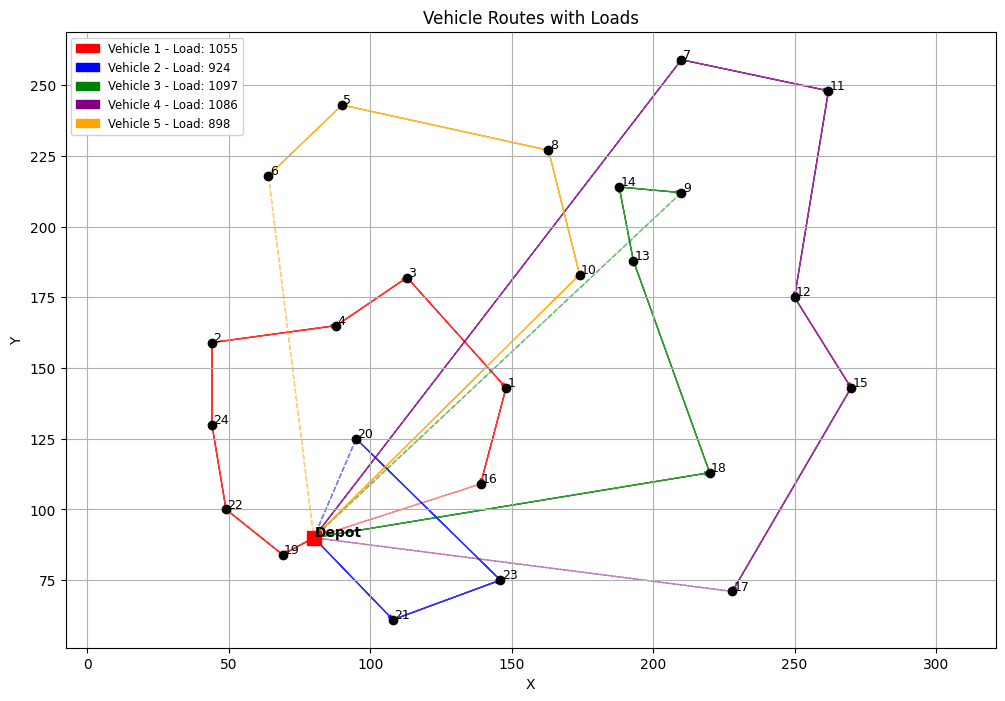

In [9]:
!pip install matplotlib

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

def plot_vehicle_routes_with_loads(routes, customers_df, vehicle_loads, depot_info):
    plt.figure(figsize=(12, 8))


    colors = ['red', 'blue', 'green', 'purple', 'orange']

    depot_df_temp = pd.DataFrame([depot_info])
    all_locations = pd.concat([depot_df_temp, customers_df], ignore_index=True)
    all_locations = all_locations.set_index('id')

    for cust_id, row in customers_df.iterrows():
        plt.plot(row['x'], row['y'], 'ko')
        plt.text(row['x'] + 0.5, row['y'] + 0.5, str(row['id']), fontsize=9)

    depot_id = depot_info['id']
    depot_x = depot_info['x']
    depot_y = depot_info['y']
    plt.plot(depot_x, depot_y, 'rs', markersize=10)
    plt.text(depot_x + 0.5, depot_y + 0.5, 'Depot', fontsize=10, fontweight='bold')


    legend_patches = []
    colors = ['red', 'blue', 'green', 'purple', 'orange']

    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        prev_id = depot_id

        for cust_id in route:

            x1, y1 = all_locations.loc[prev_id, ['x', 'y']].values
            x2, y2 = all_locations.loc[cust_id, ['x', 'y']].values
            plt.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                      head_width=1.2, alpha=0.8)
            prev_id = cust_id


        x1, y1 = all_locations.loc[prev_id, ['x', 'y']].values
        x2, y2 = depot_x, depot_y
        plt.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                  head_width=1.2, linestyle='--', alpha=0.5)

        legend_patches.append(mpatches.Patch(color=color, label=f'Vehicle {i + 1} - Load: {vehicle_loads[i]}'))

    plt.title('Vehicle Routes with Loads')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.axis('equal')
    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0, 1), fontsize='small', framealpha=0.9)
    plt.show()

from matplotlib import animation
from IPython.display import HTML

plot_vehicle_routes_with_loads(best_routes, customers_df=customers, vehicle_loads=loads, depot_info= depot)

In [ ]:
def animate_vehicle_routes_with_loads(routes, customers_df, vehicle_loads, depot_info):
    fig, ax = plt.subplots(figsize=(12, 8))

    colors = plt.cm.get_cmap('tab10', len(routes))
    depot_id = depot_info['id']
    depot_x = depot_info['x']
    depot_y = depot_info['y']

    depot_df_temp = pd.DataFrame([depot_info])
    all_locations = pd.concat([depot_df_temp, customers_df], ignore_index=True)
    all_locations = all_locations.set_index('id')

    for _, row in customers_df.iterrows():
        ax.plot(row['x'], row['y'], 'ko')
        ax.text(row['x'] + 0.5, row['y'] + 0.5, str(row['id']), fontsize=9)
    ax.plot(depot_x, depot_y, 'rs', markersize=10)
    ax.text(depot_x + 0.5, depot_y + 0.5, 'Depot', fontsize=10, fontweight='bold')

    ax.set_title('Animated Vehicle Routes')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True)
    ax.axis('equal')

    lines = []
    total_segments = sum(len(route) + 1 for route in routes)
    segments = []

    for i, route in enumerate(routes):
        color = colors(i)
        prev_id = depot_id
        for cust_id in route:
            x1, y1 = all_locations.loc[prev_id, ['x', 'y']]
            x2, y2 = all_locations.loc[cust_id, ['x', 'y']]
            segments.append((x1, y1, x2, y2, color))
            prev_id = cust_id

        x1, y1 = all_locations.loc[prev_id, ['x', 'y']]
        x2, y2 = depot_x, depot_y
        segments.append((x1, y1, x2, y2, color))


    def init():
        return []

    def animate(i):
        if i >= len(segments): return []
        x1, y1, x2, y2, color = segments[i]
        line = ax.arrow(x1, y1, x2 - x1, y2 - y1, color=color, length_includes_head=True,
                        head_width=1.2, alpha=0.8)
        lines.append(line)
        return lines

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segments) + 10,
                                   interval=500,
                                   blit=False, repeat=False)

    plt.close(fig)
    return HTML(anim.to_jshtml())

animate_vehicle_routes_with_loads(best_routes, customers_df=customers, vehicle_loads=loads, depot_info= depot)